In [1]:
import tensorflow as tf
import gc

tf.keras.backend.clear_session()
gc.collect()

2024-08-14 16:22:44.489104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 16:22:44.489220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 16:22:44.774087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


0

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Found 10000 files belonging to 10 classes.
(16, 256, 256, 3)
[5 0 0 2 8 6 8 5 6 4 0 3 4 0 1 1]


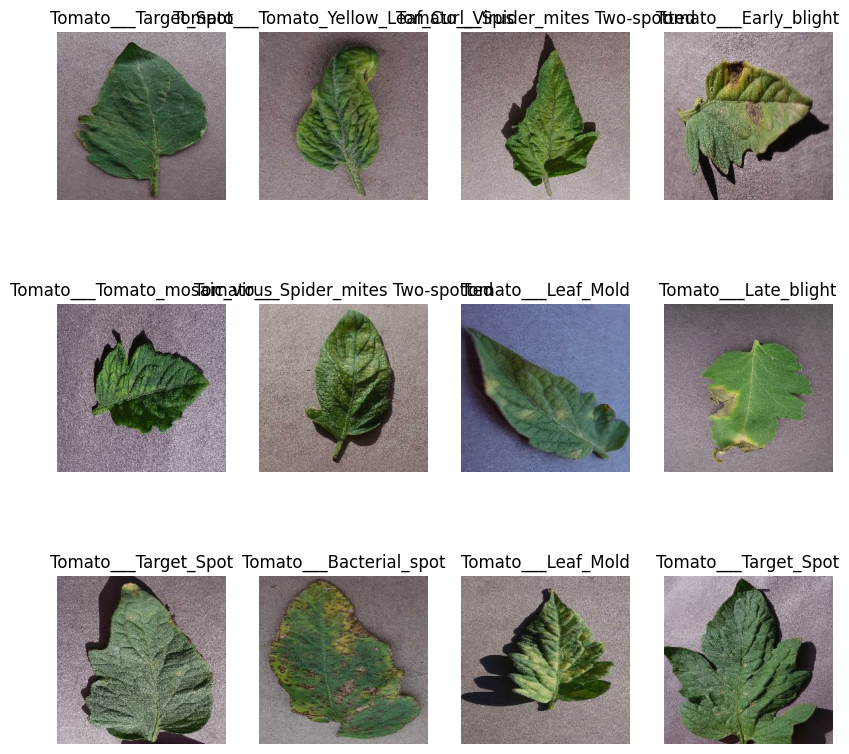

In [7]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "/kaggle/input/tomatoleaf/tomato/train",
 seed=123,
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE
)
class_names = dataset.class_names
class_names=['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset",
 seed=123,
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE
)
class_names = dataset.class_names
class_names=['Anthracnose', 'Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

NotFoundError: Could not find directory /kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset

In [8]:
len(dataset)
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
len(train_ds)
test_ds = dataset.skip(54)
len(test_ds)
val_size=0.1
len(dataset)*val_size
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2,
shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

len(train_ds)
len(val_ds)
len(test_ds)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 layers.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds = train_ds.map(
 lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11
model = models.Sequential([
 resize_and_rescale,
 layers.Conv2D(32, kernel_size = (3,3), activation='relu',
input_shape=input_shape),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Flatten(),
 layers.Dense(64, activation='relu'),
layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (16, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (16, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 11)               │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,411 (1.06 MB)

 Trainable params: 278,411 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import os
import shutil
import random
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping, ReduceLROnPlateau
save_weights_path = f"./cnn_12_layers/results/trash-model-weight.weights.h5" 
csv_path = f"./cnn_12_layers/results/12_layers.csv" 
log_dir = f"./cnn_12_layers/results/12_layers" 
os.makedirs(f"./cnn_12_layers/results", exist_ok = True)
model_checkpoints = ModelCheckpoint(save_weights_path, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
model_loggers = TensorBoard(log_dir=log_dir)
model_csvloggers = CSVLogger(csv_path, append=True)
early_stop_patience = 10
early_stop = EarlyStopping('val_accuracy', patience=early_stop_patience)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.05, patience= 2, verbose=1)
callbacks = [early_stop, reduce_lr, model_checkpoints, model_loggers, model_csvloggers]
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']
)
history = model.fit(
 train_ds,
 batch_size=BATCH_SIZE,
 validation_data=val_ds,
 verbose=1,
 epochs=50,
)

Epoch 1/50
  1/375 ━━━━━━━━━━━━━━━━━━━━ 3:36:05 35s/step - accuracy: 0.1875 - loss: 2.4198

I0000 00:00:1723652738.413392     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723652738.434709     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.1612 - loss: 2.2244

W0000 00:00:1723652848.657464     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 297ms/step - accuracy: 0.1614 - loss: 2.2239 - val_accuracy: 0.3760 - val_loss: 1.7055
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 100s 267ms/step - accuracy: 0.3939 - loss: 1.6935 - val_accuracy: 0.3850 - val_loss: 1.6571
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 99s 265ms/step - accuracy: 0.4679 - loss: 1.5101 - val_accuracy: 0.4955 - val_loss: 1.4564
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 99s 263ms/step - accuracy: 0.5415 - loss: 1.2930 - val_accuracy: 0.5350 - val_loss: 1.3341
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.6352 - loss: 1.0561 - val_accuracy: 0.5925 - val_loss: 1.4037
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 99s 264ms/step - accuracy: 0.7041 - loss: 0.8606 - val_accuracy: 0.7040 - val_loss: 0.8550
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 268ms/step - accuracy: 0.7671 - loss: 0.6774 - val_accuracy: 0.7190 - val_loss: 0.8640
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 100s 267ms/step - accuracy: 0.7962 - loss: 0.5833 

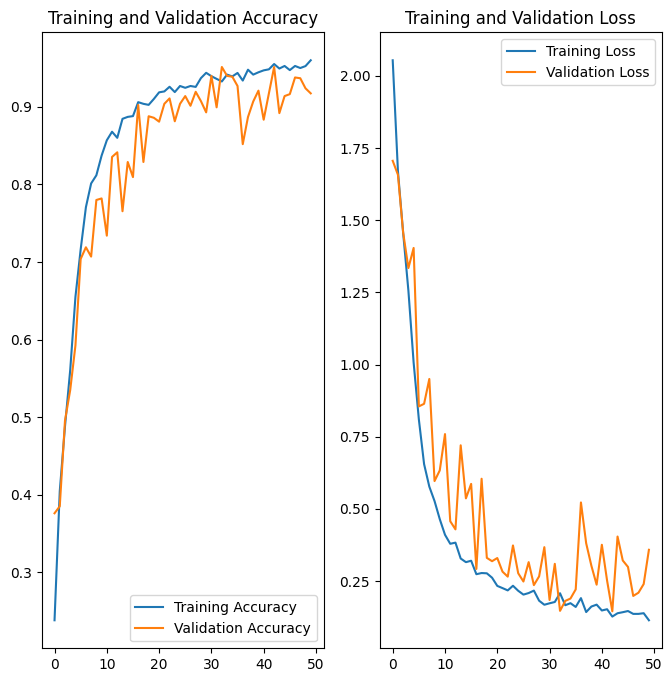

In [11]:
history
history.params
history.history.keys()
#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
type(history.history['loss'])
len(history.history['loss'])
history.history['loss'][:5]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Accuracy of CNN Model: 0.9135



Classification Report of CNN Model on Testing Set:
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.90      0.95      0.92       217
                 Tomato___Early_blight       0.88      0.99      0.93       201
                  Tomato___Late_blight       0.93      0.94      0.94       207
                    Tomato___Leaf_Mold       0.93      0.98      0.96       189
           Tomato___Septoria_leaf_spot       0.99      0.85      0.91       205
     Tomato___Spider_mites Two-spotted       0.92      0.80      0.86       182
                  Tomato___Target_Spot       0.92      0.80      0.85       213
Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.86      0.92       218
          Tomato___Tomato_mosaic_virus       0.98      0.98      0.98       177
                      Tomato___healthy       0.75      1.00      0.86     

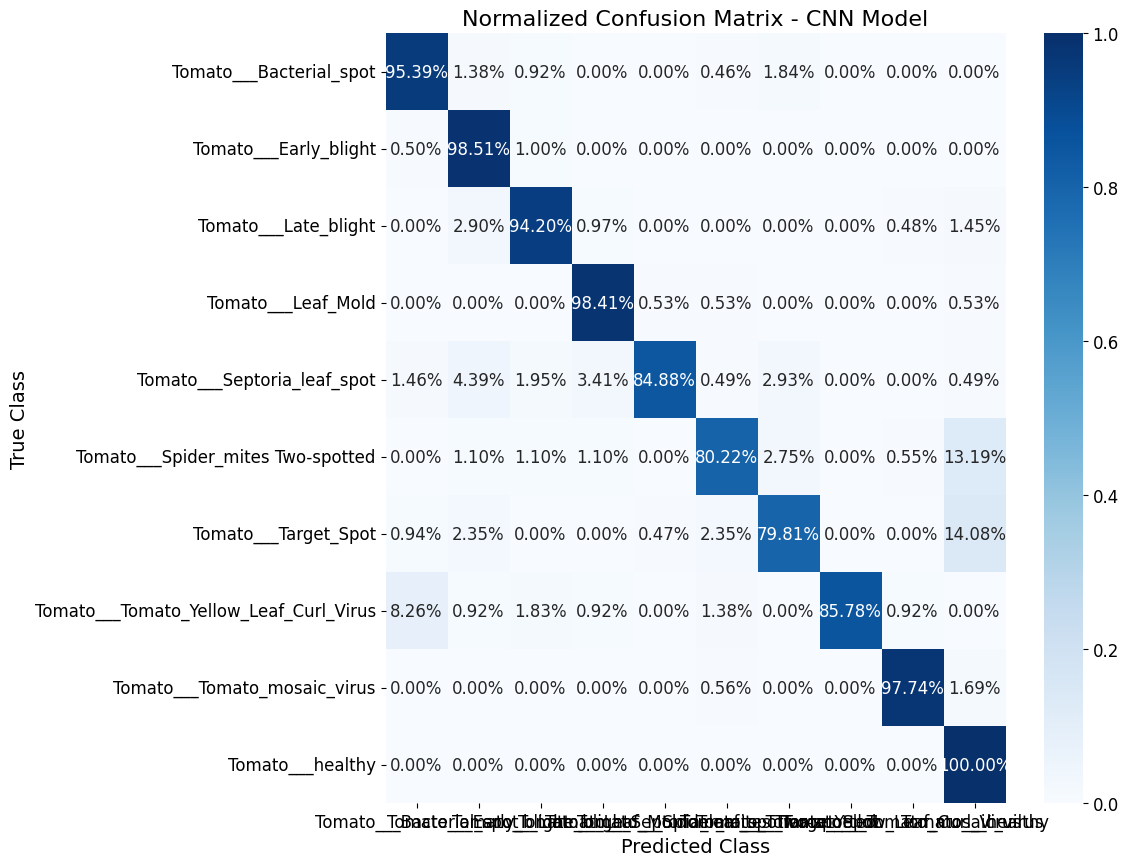

In [13]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Assuming class names are provided
class_names = ['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
# Convert test_ds to numpy arrays
x_test = []
y_test = []
for images, labels in test_ds:
 x_test.append(images.numpy())
 y_test.append(labels.numpy())
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
# Check if y_test is one-hot encoded
if y_test.ndim > 1 and y_test.shape[1] > 1:
 true_labels_test = np.argmax(y_test, axis=1)
else:
 true_labels_test = y_test
# Ensure true_labels_test and pred_labels_test are numpy arrays
true_labels_test = np.array(true_labels_test)
pred_labels_test = np.array(np.argmax(model.predict(x_test), axis=1))
# Accuracy
accuracy_on_test = accuracy_score(true_labels_test, pred_labels_test)
print(f"\nAccuracy of CNN Model: {accuracy_on_test}")
# Classification Report
print(f"\n\n\nClassification Report of CNN Model on Testing Set:")
class_report = classification_report(true_labels_test, 
pred_labels_test, target_names=class_names)
print(class_report)
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels_test, pred_labels_test, 
normalize='true')
annotations = [['{:.2%}'.format(value) for value in row] for row in
conf_matrix]
# Plotting Confusion Matrix
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(conf_matrix, annot=annotations, fmt='', 
cmap="Blues", xticklabels=class_names, yticklabels=class_names, 
annot_kws={"size": 12})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, 
rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
heatmap.collections[0].colorbar.ax.tick_params(labelsize=12)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.title('Normalized Confusion Matrix - CNN Model', fontsize=16)
plt.show()
